# Chapter: BNN (Bayesian Neural Network) Regression model
This chapter aims to show how to define a fully bayesian model for regression and how to train it using Kullback-Leibler divergence in a vanilla Pytorch implementation.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

## Data preparation and training/validation/test set preparation
This is an elementary implementation of a multi-head regression model in Pytorch using the Variance Attenuation Loss.

First we define the device (GPU/CPU) we are working with. Since we are working with simple numerical data, we choose the CPU to reduce the training time.

In [2]:
# Identify the existing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select cpu device
device = 'cpu'

The data frame is the linear relationship with homoscedastic aleatoric noise, we explicitly split the data frame into training/validation/test set.

In [3]:
chosen_df = "df_nonlinear_homoscedastic_aleatoric.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

full_df.head(8)

,x_range,y_range,split_label
0,-100.00000,-1.827437,0
1,-99.89995,-2.038570,0
2,-99.79990,-2.156036,2
3,-99.69985,-1.881278,2
4,-99.59980,-2.062530,0
5,-99.49975,-1.886184,1
6,-99.39970,-1.834947,0
7,-99.29965,-1.823319,0


We define a CustomDataset from Pytorch Dataset. The dataset has an *init* (initialise the class), a *len* and a *getitem* method.
A Dataset must provide the tools to identify available data and return all the elements needed to train/test/evaluate the model.

Can be skipped if the data is particularly simple.

In [4]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])

        features = torch.tensor([x_range], dtype=torch.float32)
        output = torch.tensor([y_range], dtype=torch.float32)
        
        return features, output

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example (x_range,y_range)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

Length training dataset: 1600
Output example (x_range,y_range)=((tensor([-96.3982]), tensor([-1.8095]))) with index 27.


To define a batch we can iterate on the whole dataset or define a *DataLoader* which samples from the introduced DataSet and can be iterated during training. It provides a batch of tensors to apply the computations efficiently at the same time.

In [5]:
# Size of each batch
batch_size = 15

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Define a Bayesian Layer
To define a fully Bayesian model for regression we need to define a single (linear) Bayesian layer.

Each weight of the layer is made up of a *mu* (the mean) and a *log_sigma* (the logarithm of the standard deviation), which together give an output corresponding to a Gaussian distribution (fully characterised as $\mathcal{N}\left(\textit{mu}, \text{exp}\left( \textit{log\_sigma} \right) \right)$).
To ensure that the *sigma* is positive, the learnable value belongs to $\mathbb{R}$ and corresponds to the logarithmic value of the standard deviation. Therefore, in the inference phase, we have to apply an exponential to make it correspond to the real standard deviation.

The prior distribution of each distribution is introduced to update it using the KL divergence.

The biases are computed in the same way (as Gaussian distributions) with their own prior distribution.

The KL divergence is computed for the weights/biases of this layer and is added to all Bayesian layers to define the loss.

In [6]:
class LinearBayesianLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, prior_std=1.0):
        '''
        in_features: (int) number of input features
        out_features: (int) number of output features
        bias=Ture: (bool) add bias to mu and std
        prior_std: (float>0) standard deviation of prior distributions
        '''
        
        super().__init__()

        self.bias = bias

        # Learnable mean and log-standard_deviation
        # Define a (non-initialized) tensor with in_features to out_features dimensions
        self.mu = torch.empty(out_features, in_features)  
        # Random Gaussian initialization from values sampled from N(mean=0, std=0.1) 
        self.mu.normal_(0, 0.1)  
        # Make it a trainable parameter
        self.mu = nn.Parameter(self.mu)   

        # Initialize a trainable parameter with in_features to out_features to -5
        self.log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5)) 

        # Fixed prior N(mean=0, std=prior_std) to compute KL divergence
        self.prior_mu = torch.zeros_like(self.mu)
        self.prior_sigma = torch.full_like(self.mu, prior_std)

        
        # The bias is another (distributional) trainable tensor
        if self.bias:
            # Initialize a learnable mean of bias
            self.mu_bias = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        
            # Initialize a learnable std of bias
            self.log_sigma_bias = nn.Parameter(torch.Tensor(out_features).fill_(-5))

            # Fixed prior N(mean=0, std=prior_std) to compute bias KL divergence
            self.prior_mu_bias = torch.zeros_like(self.mu_bias)
            self.prior_sigma_bias = torch.full_like(self.mu_bias, prior_std)



    def forward(self, x, freezed = False):
        '''
        x: (tensor) input tensor
        freezed=False: (bool) if True, freeze all the std and make the network determistic
        
        RETURN: (w*x + bias)
        '''
        
        if freezed:
            # Define each weight as the average value self.mu
            weights = self.mu 

            if self.bias:
                # Define each bias as the average bias
                bias = self.mu_bias 
                
        else:
            # Sample weights using reparameterization trick: the weight is the N(mu, sigma) = mu + sigma*N(0,1)
            epsilon_w = torch.randn_like(self.mu)       # Random N(0,1) sampling
            sigma_w = torch.exp(self.log_sigma) + 1e-6  # Ensure positivity
            weights = self.mu + sigma_w * epsilon_w     # Sampled weights

            if self.bias:
                # Sample bias using reparameterization trick
                epsilon_b = torch.randn_like(self.mu_bias)       # Random N(0,1) sampling
                sigma_b = torch.exp(self.log_sigma_bias) + 1e-6  # Ensure positivity
                bias = self.mu_bias + sigma_b * epsilon_b        # Sampled bias

        if self.bias:    
            return F.linear(x, weights, bias)
        else:
            return F.linear(x, weights)

    
    
    def kl_divergence(self):
        '''
        Compute the KL divergence on each layer
        '''
        
        # Get the device of model parameters
        device = self.mu.device  

        # Set up the weights prior distribution as normal (prior_mu, prior_sigma)
        prior_w = torch.distributions.Normal(self.prior_mu.to(device), self.prior_sigma.to(device))
        
        # Set up the weights posterior distribution as normal (mu, sigma)
        posterior_w = torch.distributions.Normal(self.mu.to(device), torch.exp(self.log_sigma).to(device))
        
        # Compute KL divergence for the weights of this layer
        kl_w = torch.distributions.kl_divergence(posterior_w, prior_w).sum()  # KL for weights

        
        if self.bias:
            # Set up the prior bias distribution as normal (prior_mu_bias, prior_sigma_bias)
            prior_b = torch.distributions.Normal(self.prior_mu_bias.to(device), self.prior_sigma_bias.to(device))
            
            # Set up the posterior bias distribution as normal (mu_bias, sigma_bias)
            posterior_b = torch.distributions.Normal(self.mu_bias.to(device), torch.exp(self.log_sigma_bias).to(device))

        # Compute KL divergence for the bias of this layer
        kl_b = torch.distributions.kl_divergence(posterior_b, prior_b).sum()  # KL for bias

        if self.bias:
            return kl_w + kl_b  # Sum both KL divergences
        else:
            return kl_w

## Define a Bayesian model:
We can now introduce the model, following the structure of the corresponding deterministic counterpart, by replacing each deterministic linear layer with a Bayesian one.

We defined additional module methods to compute the KL divergence as an average of the KL over the layers, a *MC_forward* method to derive statistics from multiple model runs, and a *Frozen_forward* method to compute a (deterministic) output given all weights frozen to their mean.

In [7]:
class BayesianModelRegression(nn.Module):
    
    def __init__(self):    
        super().__init__()

        # We store all the bayesian layers in a list to compute efficiently the KL divergence
        self.bayesian_layers = nn.ModuleList([
            LinearBayesianLayer(1, 8),
            LinearBayesianLayer(8, 16),
            LinearBayesianLayer(16, 32),
            LinearBayesianLayer(32, 16),
            LinearBayesianLayer(16, 16),
            LinearBayesianLayer(16, 1)
        ])

    
    def forward(self, x, freezed = False):
        '''
        Define the sequential network by connecting LinearBayesianLayer with a ReLU activation function.

        x: (tensor) input tensor of the model
        freezed=False: (bool)

        RETURN: x (tensor) prediction
        '''
        
        for layer in self.bayesian_layers[:-1]:  
            x = layer(x, freezed)
            x = torch.relu(x)

        # Last layer without activation function for regression
        x = self.bayesian_layers[-1](x, freezed)
        
        return x

    
    def MC_forward(self, x, n_iter=1000):
        '''
        Monte Carlo forward iterations.

        To get the result of a BNN as a mean and a standard deviation, 
        we have to run the model several times and calculate statistics on the outputs.

        x: (tensor) input tensor of the model
        n_iter=1000: (int) number of iteratons to compute MC estimates

        RETURN: mean_pred, std_pred (tuple of floats) 
        '''
        
        # Apply n_iter times the BNN model
        predictions = torch.stack([self.forward(x) for _ in range(n_iter)], dim=0)  # Shape: [n_iter, batch_size, output_dim]

        # Compute mean over MC iterations
        mean_pred = predictions.mean(dim=0)  

        # Compute standard deviation over MC iterations
        std_pred = predictions.std(dim=0)    

        # Return mean and std
        return mean_pred, std_pred  

    
    def Frozen_forward(self, x):
        '''
        Freeze all the stds of the BNN and compute the (deterministic) output considering the weights as deterministic 
        values fixed to the means.

        x: (tensor) input tensor of the model

        RETURN: x (tensor) prediction
        '''
        
        return self.forward(x, freezed = True)

    
    def kl_divergence(self):
        '''
        Average of the KL divergence of all Bayesian layers in the model.
        '''
        
        return sum(layer.kl_divergence() for layer in self.bayesian_layers)/ len(self.bayesian_layers)


# Initialize the model:
model = BayesianModelRegression()

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

Introduce the loss and the optimiser. Both can be implemented explicitly. 

For BNNs computed using Variational Inference (VI), the loss is defined as the standard MSE (on the prediction) plus the KL divergence (multiplied by a beta term) averaged over all Bayesian layers.

In [8]:
# Loss function MSE (on prediction) + KL (on all Bayesian layers)
def loss_BNN(y_pred, y_true, kl_div, beta=1e-5):

    # Standard regression loss
    mse = F.mse_loss(y_pred, y_true, reduction='mean')  

    # Combine MSE with KL divergence
    return mse + beta * kl_div  

# Alternative loss where MSE (increase average predictions) plays a major role in the first epochs and then decreases (increase uncertainties understanding)
def adaptive_loss_BNN(y_pred, y_true, kl_div, epoch, total_epochs):

    # Increase over time
    beta = (epoch / total_epochs) * 1e-3  

    # Standard regression loss
    mse = F.mse_loss(y_pred, y_true, reduction='mean')

    # Combine MSE with KL divergence
    return mse + beta * kl_div  
   

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle: 
- The model is trained for a given number of epochs *n_epochs*
- Each epoch iterates over the entire dataset (*shuffle == True* just randomly shuffles indices) using the dataloader to generate batches.
- For each batch, the gradients are computed on the whole batch to the respect of the loss function and the optimizer it is used to update model trainable parameters


In [9]:
# Number of training epochs:
n_epochs = 30

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  
        y_model = y_model.to(device)
        
        # Get total KL divergence
        kl_div = model.kl_divergence()  
        kl_div = kl_div.to(device)
        
        # Compute loss (supervised case)
        loss = loss_BNN(y_model, y_output, kl_div)

        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

            # Forward pass (model calls)
            y_model = model(x_input)
            y_model = y_model.to(device)
            
            # Get total KL divergence
            kl_div = model.kl_divergence() 
            kl_div = kl_div.to(device)
        
            # Compute loss (supervised case)
            loss = loss_BNN(y_model, y_output, kl_div)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            
    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/30], Loss: 0.8081, Val. Loss: 0.4749
Epoch [2/30], Loss: 0.4359, Val. Loss: 0.3212
Epoch [3/30], Loss: 0.2498, Val. Loss: 0.1721
Epoch [4/30], Loss: 0.1387, Val. Loss: 0.1148
Epoch [5/30], Loss: 0.1125, Val. Loss: 0.0941
Epoch [6/30], Loss: 0.1045, Val. Loss: 0.0900
Epoch [7/30], Loss: 0.0951, Val. Loss: 0.0809
Epoch [8/30], Loss: 0.0921, Val. Loss: 0.0840
Epoch [9/30], Loss: 0.0851, Val. Loss: 0.0855
Epoch [10/30], Loss: 0.0831, Val. Loss: 0.0844
Epoch [11/30], Loss: 0.0796, Val. Loss: 0.0768
Epoch [12/30], Loss: 0.0788, Val. Loss: 0.0715
Epoch [13/30], Loss: 0.0711, Val. Loss: 0.0690
Epoch [14/30], Loss: 0.0673, Val. Loss: 0.0727
Epoch [15/30], Loss: 0.0681, Val. Loss: 0.0704
Epoch [16/30], Loss: 0.0708, Val. Loss: 0.0566
Epoch [17/30], Loss: 0.0603, Val. Loss: 0.0596
Epoch [18/30], Loss: 0.0602, Val. Loss: 0.0820
Epoch [19/30], Loss: 0.0590, Val. Loss: 0.0476
Epoch [20/30], Loss: 0.0568, Val. Loss: 0.0564
Epoch [21/30], Loss: 0.0560, Val. Loss: 0.0652
Epoch [22/30], Loss: 0

Plot the convergence graphs on training and validation sets:

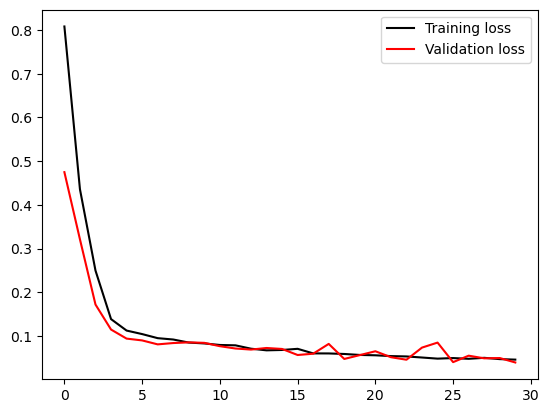

In [10]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

## Show predictions
Plot the training data set against the predictions using the Frozen_forward method. The network will therefore produce outputs taking into account the weights equal to the means.

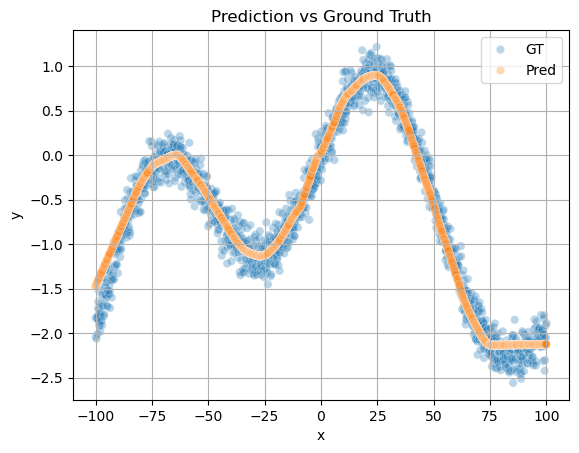

In [11]:
# Set up the model to evaluation mode:
model.eval()

# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # Ground Truth

# Get predictions using Frozen_forward method
with torch.no_grad():
    prediction_plot = [float(model.Frozen_forward(torch.tensor(i).view(1).to(device).float().unsqueeze(1))[0].to('cpu')) for i in x_plot]

# Create a DataFrame for plotting
df_plot_train = pd.DataFrame({
    "x": np.append(x_plot, x_plot),
    "y": np.append(y_plot, prediction_plot),
    "GT/Pred": np.append(["GT"] * len(y_plot), ["Pred"] * len(prediction_plot))
})

# Scatter plot of GT and predictions
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha=0.3)

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction vs Ground Truth')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

Standard predictions are inherently random, as each (stochastic) forward pass sample is taken randomly from the weight distributions:

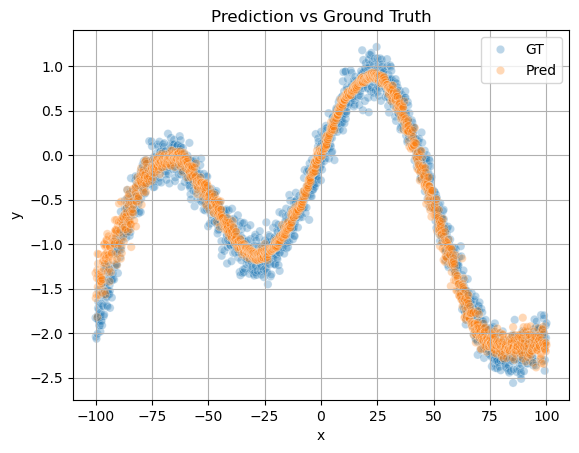

In [12]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # Ground Truth

# Set up the model to evaluation mode:
model.eval()

# Get predictions
with torch.no_grad():
    prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float().unsqueeze(1))[0].to('cpu')) for i in x_plot]

# Create a DataFrame for plotting
df_plot_train = pd.DataFrame({
    "x": np.append(x_plot, x_plot),
    "y": np.append(y_plot, prediction_plot),
    "GT/Pred": np.append(["GT"] * len(y_plot), ["Pred"] * len(prediction_plot))
})

# Scatter plot of GT and predictions
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha=0.3)

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction vs Ground Truth')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

Collect the MC_forward predictions (calculated as mean and std) and plot them to identify the confidence intervals)

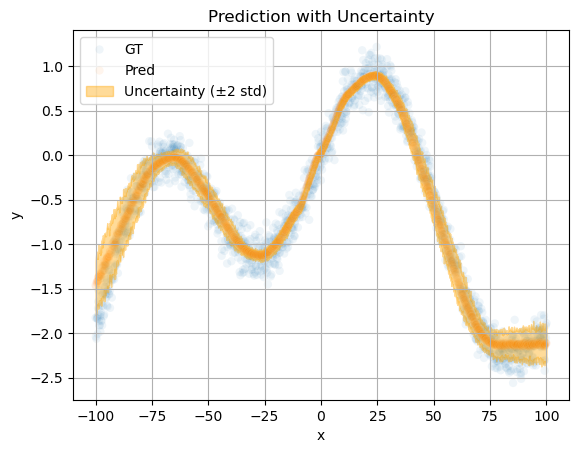

In [13]:
# Define the number of iterations at each MC_forward pass
tmp_iter = 50

# Set up the model to evaluation mode:
model.eval()

# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # GT

# Select a subset (10% of the training set) to speed up computation
x_plot_sampled = x_plot[::10]  # Take every 10th element from x_plot
y_plot_sampled = y_plot[::10]  # Take every 10th element from y_plot

# Compute model outputs - Computationally burdensome
with torch.no_grad():
    tuple_predictions = [model.MC_forward(torch.tensor(i).view(1).to(device).float(), n_iter = tmp_iter) for i in x_plot]

# Divide outputs as predictions and stds:
prediction_plot = [i[0].to('cpu').item()  for i in tuple_predictions]
std_plot = [i[1].to('cpu').item()  for i in tuple_predictions]

# Define the dataframe
df_plot_train = pd.DataFrame({
    "x": np.append(x_plot, x_plot),
    "y": np.append(y_plot, prediction_plot),
    "GT/Pred": np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))
})

# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha=0.07)

# Create the prediction bounds for the color zone (±2 std)
lower_bound = np.array(prediction_plot) - 2 * np.array(std_plot)
upper_bound = np.array(prediction_plot) + 2 * np.array(std_plot)

# Add the shaded region between lower_bound and upper_bound
plt.fill_between(x_plot, lower_bound, upper_bound, color='orange', alpha=0.4, label="Uncertainty (±2 std)")

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction with Uncertainty')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

As expected, most of the uncertainty is concentrated around the boundaries of the training set, while the aleatoric (noise) component in the central part of the set is neglected.
This is an example of how (one-headed) BNNs are able to identify epistemic uncertainty and are less prone to correctly characterise aleatoric uncertainty.

In summary, given an input value *x_prova*: 
- the *forward* pass provides a (stochastic) random value sampled from the weights
- the *MC_forward* computes the forward pass several times and collects the sample mean and standard deviation
- The *Frozen_forward* computes the deterministic output of the network, using the mean weights as the deterministic ANN counterpart.

In [14]:
# Select the test point
x_prova = x_plot[1500]

# Evaluation mode
model.eval()

with torch.no_grad():
    # One (stochastic) forward pass
    print("\n Standard forward: ", float(model(torch.tensor(x_prova).view(1).to(device).float().unsqueeze(1))[0].to('cpu')))
    
    # One average Monte Carlo forward pass obtained by applying n_iter times the (stochastic) forward pass
    print("\n MC_forward: ",model.MC_forward(torch.tensor(x_prova).view(1).to(device).float(), n_iter=1000))
    
    # One (determistic) forward pass using the average weights
    print("\n Frozen_forward: ", model.Frozen_forward(torch.tensor(x_prova).view(1).to(device).float()))


 Standard forward:  -2.278480052947998

 MC_forward:  (tensor([-2.1255]), tensor([0.0883]))

 Frozen_forward:  tensor([-2.1304])
